In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transformer_model = nn.Transformer(batch_first=True)
BATCH_SIZE = 1
ENC_SEQ_LEN = 10
DEC_SEQ_LEN = 1
src = torch.rand((BATCH_SIZE, ENC_SEQ_LEN, transformer_model.d_model))
tgt = torch.rand((BATCH_SIZE, DEC_SEQ_LEN, transformer_model.d_model))
out = transformer_model(src, tgt)
out.flatten(start_dim=1).shape, out.shape

(torch.Size([1, 512]), torch.Size([1, 1, 512]))

In [3]:
encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=3, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)


In [4]:
BATCH_SIZE = 1
ENC_SEQ_LEN = 15
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
ENC_SEQ_LEN = 16
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
out.shape, src

(torch.Size([1, 16, 6]),
 tensor([[[0.5532, 0.9508, 0.3200, 0.9720, 0.7370, 0.2842],
          [0.7998, 0.7184, 0.3298, 0.9565, 0.2556, 0.7044],
          [0.6701, 0.1755, 0.3876, 0.2870, 0.3231, 0.5246],
          [0.7647, 0.3738, 0.5676, 0.9799, 0.0735, 0.6073],
          [0.0355, 0.8399, 0.1399, 0.9451, 0.5935, 0.8280],
          [0.4018, 0.8727, 0.5918, 0.8244, 0.9035, 0.3623],
          [0.0616, 0.6059, 0.4625, 0.2954, 0.3453, 0.3096],
          [0.8777, 0.0323, 0.2299, 0.6096, 0.3262, 0.4576],
          [0.7800, 0.8173, 0.6206, 0.6668, 0.9010, 0.0531],
          [0.9385, 0.2296, 0.6795, 0.7442, 0.9245, 0.8389],
          [0.2844, 0.6376, 0.7467, 0.1270, 0.5395, 0.6878],
          [0.4771, 0.5734, 0.4899, 0.4599, 0.4496, 0.6311],
          [0.2473, 0.6499, 0.6798, 0.0521, 0.2924, 0.4787],
          [0.2998, 0.6012, 0.1984, 0.7895, 0.1669, 0.1086],
          [0.2918, 0.6143, 0.9241, 0.9024, 0.4677, 0.9549],
          [0.2667, 0.0040, 0.0710, 0.6069, 0.8589, 0.0571]]]))

In [5]:
data_dir = "indoor_forward_9_snapdragon_with_gt/"
imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
imu_df_nostamp = imu_df.loc[:, imu_df.columns != 'timestamp']
imu_df.index = pd.to_datetime(imu_df["timestamp"], unit='s')
imu_df

,timestamp,ang_vel_x,ang_vel_y,ang_vel_z,lin_acc_x,lin_acc_y,lin_acc_z
timestamp,,,,,,,
2018-10-29 14:20:16.292325120,1.540823e+09,-0.006392,-0.008522,-0.007457,0.052672,-0.158017,9.797023
2018-10-29 14:20:16.294326016,1.540823e+09,-0.005326,-0.006392,-0.006392,0.000000,-0.129286,9.768292
2018-10-29 14:20:16.296323072,1.540823e+09,-0.010653,-0.007457,-0.001065,-0.033519,-0.100556,9.749139
2018-10-29 14:20:16.298322944,1.540823e+09,-0.009587,-0.009587,-0.002131,0.043095,-0.110133,9.725197
2018-10-29 14:20:16.300322048,1.540823e+09,-0.005326,-0.005326,-0.004261,0.047884,-0.134075,9.782658
...,...,...,...,...,...,...,...
2018-10-29 14:21:33.118321920,1.540823e+09,-0.214118,-0.024501,0.415453,-5.956743,-0.397435,7.086801
2018-10-29 14:21:33.120321024,1.540823e+09,-0.238619,0.060720,0.476173,7.110743,1.402995,5.717324
2018-10-29 14:21:33.122322944,1.540823e+09,-0.295078,0.106526,0.288687,-3.969566,-0.181958,16.136837


In [6]:
imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
imu_data = torch.from_numpy(imu_data)
imu_data

tensor([[-6.3916e-03, -8.5221e-03, -7.4569e-03,  5.2672e-02, -1.5802e-01,
          9.7970e+00],
        [-5.3263e-03, -6.3916e-03, -6.3916e-03,  0.0000e+00, -1.2929e-01,
          9.7683e+00],
        [-1.0653e-02, -7.4569e-03, -1.0653e-03, -3.3519e-02, -1.0056e-01,
          9.7491e+00],
        ...,
        [-2.9508e-01,  1.0653e-01,  2.8869e-01, -3.9696e+00, -1.8196e-01,
          1.6137e+01],
        [-7.8830e-02, -7.3503e-02,  4.6019e-01, -1.6280e+00,  9.0979e-02,
          1.6472e+00],
        [-3.4834e-01,  3.0893e-02,  3.9202e-01,  6.1435e+00,  2.1596e+00,
          9.7204e+00]])

In [7]:
src = imu_data[:ENC_SEQ_LEN].unsqueeze(0)
transformer_encoder(src)

tensor([[[ 1.1471, -0.5098,  0.3392, -1.4976, -0.7219,  1.2431],
         [ 0.7496, -0.6678,  0.5827, -1.5721, -0.4868,  1.3944],
         [ 1.1653, -0.7689,  0.5677, -1.6836, -0.2040,  0.9234],
         [ 0.8794, -0.6514,  0.6033, -1.5389, -0.6001,  1.3077],
         [ 0.6210, -0.8199,  0.7399, -1.5866, -0.2929,  1.3384],
         [ 0.7553, -0.6940,  0.3530, -1.6384, -0.2215,  1.4456],
         [ 0.8353, -0.4616,  0.3270, -1.6278, -0.5117,  1.4389],
         [ 1.3666, -0.3743,  0.4358, -1.3755, -1.0033,  0.9507],
         [ 0.7842, -0.5383,  0.3542, -1.7265, -0.2597,  1.3862],
         [ 0.7738, -0.5129,  0.3058, -1.8102, -0.0834,  1.3269],
         [ 0.5307, -0.6621,  0.7817, -1.7246, -0.2103,  1.2847],
         [ 1.1009, -0.6307,  0.6811, -1.6290, -0.5223,  1.0000],
         [ 0.7852, -0.5646,  0.6742, -1.8031, -0.2339,  1.1420],
         [ 0.6563, -0.7355,  0.7394, -1.6785, -0.2478,  1.2660],
         [ 1.2558, -0.5230,  0.1158, -1.6169, -0.3990,  1.1672],
         [ 0.7349, -0.715

In [8]:
class IMUDataset(Dataset):
    def __init__(self, data_dir, label_file, seq_len):
        imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
        self.imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
        self.imu_df.index = pd.to_datetime(self.imu_df["timestamp"], unit='s')
        imu_df_nostamp = self.imu_df.loc[:, self.imu_df.columns != 'timestamp']
        self.imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
        self.imu_data = torch.from_numpy(self.imu_data)

        label_cols=["timestamp","tx","ty","tz","qx","qy","qz","qw","none"]
        self.labels_df = pd.read_csv(label_file, delimiter=' ', skiprows=1, names=label_cols)
        self.labels_df = self.labels_df.iloc[: , :-1]
        self.labels_df["timestamp"] = pd.to_datetime(self.labels_df["timestamp"], unit='s')
        labels_df_nostamp = self.labels_df.loc[:, self.labels_df.columns != 'timestamp']
        self.labels = torch.tensor(labels_df_nostamp.to_numpy(), dtype=torch.float32)

        self.seq_len = seq_len
        self.delta = seq_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        # TODO: could optimize for better performance (pretty quick anyway)
        label_ts = self.labels_df.iloc[idx]["timestamp"]
        label_ts_end = self.labels_df.iloc[idx+self.delta]["timestamp"]
        l1 = self.labels[idx]
        l2 = self.labels[idx+self.delta]
        dl = l2-l1
        label = dl[:3] # linear acc
        imu_index_start = self.imu_df.index.get_loc(label_ts, method='nearest')
        imu_index_end = self.imu_df.index.get_loc(label_ts_end, method='nearest')
        imu = self.imu_data[imu_index_start:imu_index_end]
        return imu, label

ENC_SEQ_LEN = 256
vio_dataset = IMUDataset(data_dir, data_dir + "groundtruth.txt", ENC_SEQ_LEN)
vio_dataset.__getitem__(0)

(tensor([[-1.5766e-01, -1.0866e-01, -2.0240e-02,  2.3655e+00, -1.6376e+00,
           4.9895e+00],
         [-2.9827e-01,  8.0960e-02,  7.4569e-03, -3.0837e+00,  4.5633e+00,
           1.3125e+01],
         [ 1.2783e-02,  1.2890e-01,  1.5340e-01,  2.5378e+00, -2.7773e-01,
           1.1152e+01],
         ...,
         [ 2.2051e-01, -6.8177e-02,  7.0307e-02,  7.2783e-01, -2.3702e+00,
           5.9280e+00],
         [ 6.7112e-02,  4.9002e-02,  4.2611e-02,  1.2354e+00, -3.0694e+00,
           5.9136e+00],
         [-1.9601e-01,  1.1718e-01, -9.8004e-02,  1.0199e+00,  1.8962e+00,
           1.1746e+01]]),
 tensor([-0.0022, -0.0071, -0.0011]))

In [10]:
data_point = vio_dataset.__getitem__(0)[0].unsqueeze(0)
transformer_encoder(data_point).shape

torch.Size([1, 256, 6])

In [11]:
class IMUTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=6, dim_feedforward=32, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.encoder = transformer_encoder
        self.fc1 = nn.Linear(in_features=6, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.relu(self.fc1(x[:,-1,:]))
        x = self.fc2(x)
        return x

model = IMUTransformer()
model(data_point)

tensor([[-0.2899,  0.1247,  0.2791]], grad_fn=<AddmmBackward0>)

In [12]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=32, shuffle=True, num_workers=4)
next(iter(dataloader))[0].shape

torch.Size([32, 256, 6])

In [13]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # labels =  torch.ones_like(labels).to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch 0/19
----------
train Loss: 1.3567
Epoch 1/19
----------
train Loss: 0.7178
Epoch 2/19
----------
train Loss: 0.4886
Epoch 3/19
----------
train Loss: 0.3784
Epoch 4/19
----------
train Loss: 0.3111
Epoch 5/19
----------
train Loss: 0.2588
Epoch 6/19
----------
train Loss: 0.2274
Epoch 7/19
----------
train Loss: 0.1992
Epoch 8/19
----------
train Loss: 0.1764
Epoch 9/19
----------
train Loss: 0.1520
Epoch 10/19
----------
train Loss: 0.1321
Epoch 11/19
----------
train Loss: 0.1180
Epoch 12/19
----------
train Loss: 0.1058
Epoch 13/19
----------
train Loss: 0.0964
Epoch 14/19
----------
train Loss: 0.0883
Epoch 15/19
----------
train Loss: 0.0802
Epoch 16/19
----------
train Loss: 0.0801
Epoch 17/19
----------
train Loss: 0.0737
Epoch 18/19
----------
train Loss: 0.0667
Epoch 19/19
----------
train Loss: 0.0650


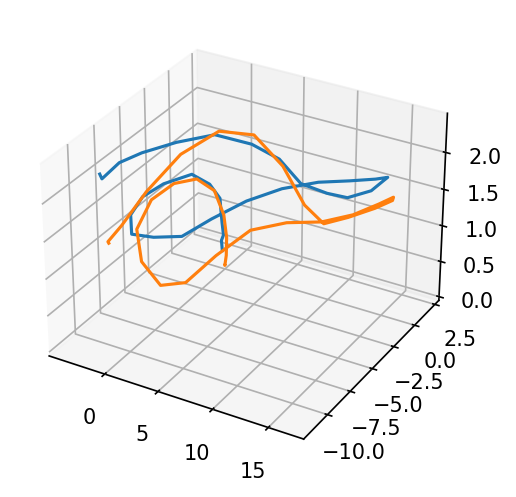

In [14]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(34):
    data_point = vio_dataset.__getitem__(i*ENC_SEQ_LEN)
    delta_label = data_point[1].numpy().reshape(3,1)
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])
# 11,24

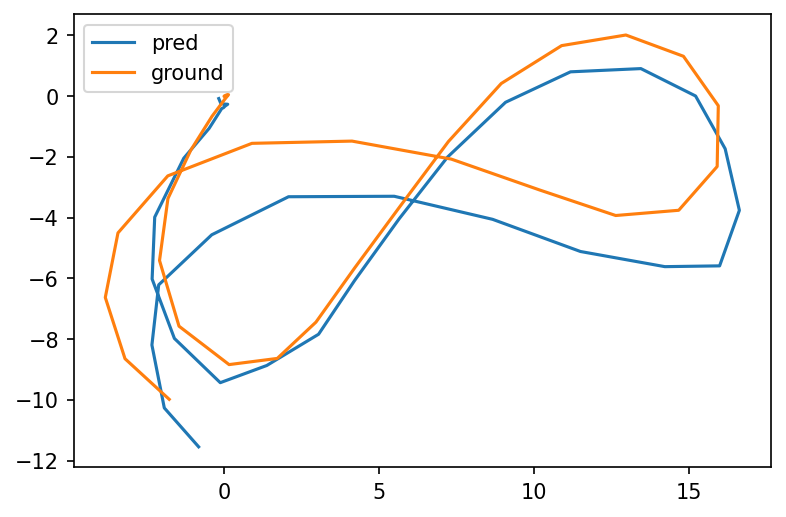

In [24]:
plt.figure(dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])

In [23]:
np.linalg.norm(path[-1] - ground[-1])

2.142546223913219